# $$ Stock\  Price\ Prediction\ and\ Analysis $$
## $$ IT \ Coding \ Project,\ Module \ II $$
### $$ Tommaso \ Grandi, Student ID \ 5200990$$


For the project of the second module of IT coding I chose the Stock Price Prediction, but I also decided to extend this prediction and implement it into a web dashboard that could allow the user to select a stock, visualize informations and request a prediction based on two main models: ARIMA and XGBOOST. 

For this reason the code  consists of two parts:
1. The current notebook represents an in depth explanation and thougt process of the stages of data gathering, processing, analysis and the creation of the predicting techniques. In the notebook there is also the explanation of the functions created to display the data and the outcome of the predictions inside a web app DashBoard created through the Streamlit Library. 

2. Additionally there is the dashboard.py script that contains synthetically the most important parts presented in the notebook, the functions that are used to manipulate the data and the whole interface of the dashboard. This script is the one to be runned by streamlit in order to access the dashboard and interact with it. 

See README for the explanation on how to run the dashboard and interact with it. 

#### Import libraries and dependencies

In [2]:
import pandas as pd # for dataframes and manipulation 
import yfinance as yf # for downloading data
import numpy as np
from scipy.optimize import minimize

# for technical analysis
import ta.trend as tt 
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator

# for plotting
import matplotlib.pyplot as plt 
import plotly.express as px
from plotly.subplots import make_subplots
# import plotly.io as pio
# pio.renderers.default = "svg"

# to create and ARIMA model
import pmdarima as pm

import os

In [103]:
# Setting style for every plot
plt.style.use('seaborn')

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_55270/3415471106.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



## 1. Data gathering and pre-processing

### 1.1 Webscraping companies' tickers and names

In order to create a list of companies to be displayed and the selected by user from the streamlit selectboxes, we'll webscrape the list of companies traded in a market from wikipedia in order to get the company full name and its ticker.

In [46]:
SP500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
SP500 = SP500[0] #take just the first table from the webpage
SP500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [47]:
# zip is a Python function that will iteratively aggregate the two elements (Ticker and the name of the security)
# then the dict() function create a dictionary with keys the names from 'Security' column and values the tickers from the 'Symbol' column
ticks_SP500 = dict(zip(SP500['Security'], SP500['Symbol']))

In [ ]:
# We can now repeat the same process for Nasdaq and FTSEMIB
FTSEMIB = pd.read_html('https://en.wikipedia.org/wiki/FTSE_MIB')
FTSEMIB = FTSEMIB[1]

NASDAQ = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100#Components')
NASDAQ = NASDAQ[4]

In [ ]:
FTSEMIB.head()

,Company,Ticker,ISIN,ICB Sector
0,A2A,A2A.MI,IT0001233417,7530 (Electricity)[citation needed]
1,Amplifon,AMP.MI,IT0004056880,(Health Care)
2,Azimut,AZM.MI,IT0003261697,8770 (Financial Services)[citation needed]
3,Banca Generali,BGN.MI,IT0001031084,8770 (Financial Services)
4,Banca Mediolanum,BMED.MI,IT0004776628,8770 (Financial Services)


In [ ]:
NASDAQ.head()

,Company,Ticker,GICS Sector,GICS Sub-Industry
0,Activision Blizzard,ATVI,Communication Services,Interactive Home Entertainment
1,Adobe Inc.,ADBE,Information Technology,Application Software
2,ADP,ADP,Information Technology,Data Processing & Outsourced Services
3,Airbnb,ABNB,Consumer Discretionary,Internet & Direct Marketing Retail
4,Align Technology,ALGN,Health Care,Health Care Supplies


In [ ]:
ticks_FTSE = dict(zip(FTSEMIB['Company'], FTSEMIB['Ticker']))
ticks_NASDAQ = dict(zip(NASDAQ['Company'], NASDAQ['Ticker']))

### 1.2 Gather data using tickers and Yahoo Finance API's

The main libraries we will use to download data for a security are `yahoo_fin` and `yfinance`.

The function to download data using yfinance is .download() that take as inputs the company ticker, start date and end date of the period we want to download data.

For the rest of this notebook we'll use the data referred to AAPL stock price stored in the ``data`` dataframe. 

In [1566]:
data = yf.download('AAPL', start='2000-01-01')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.849468,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.777850,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.789232,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.720933,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.755083,460734400


The function return a pandas dataframe with different columns that include informations about the opening and the closing price, the range min-max of the price of the security, the adjusted close price and the volumes traded in a specific day.

The second library that will be used is yahoo_fin. 

The first function `get_stats` is useful to download statistics about a company and `get_analysts_info` will scrape analysts' estimates.

In [1033]:
from yahoo_fin.stock_info import get_stats, get_analysts_info

stats = get_stats('AAPl')
info = get_analysts_info('AAPL')

In [1034]:
stats.head()

,Attribute,Value
0,Beta (5Y Monthly),1.30
1,52-Week Change 3,22.09%
2,S&P500 52-Week Change 3,4.19%
3,52 Week High 3,176.39
4,52 Week Low 3,124.17


In [1035]:
info

{'Earnings Estimate':   Earnings Estimate  Current Qtr. (Jun 2023)  Next Qtr. (Sep 2023)  \
 0   No. of Analysts                    27.00                 26.00   
 1     Avg. Estimate                     1.19                  1.36   
 2      Low Estimate                     1.05                  1.17   
 3     High Estimate                     1.45                  1.51   
 4      Year Ago EPS                     1.20                  1.29   
 
    Current Year (2023)  Next Year (2024)  
 0                35.00             35.00  
 1                 5.97              6.54  
 2                 5.43              5.58  
 3                 6.29              7.25  
 4                 6.11              5.97  ,
 'Revenue Estimate':           Revenue Estimate Current Qtr. (Jun 2023) Next Qtr. (Sep 2023)  \
 0          No. of Analysts                      24                   24   
 1            Avg. Estimate                  81.51B               90.52B   
 2             Low Estimate           

The following function from `yahoo_fin` will be used to download the live stock price

In [45]:
from yahoo_fin.stock_info  import get_live_price

print(get_live_price('AAPL'))

175.16000366210938


## 2. Stock prediction

### 2.1 Stock Prediction

### 2.1.1 ARIMA Models

ARIMA models, or Auto Regressive Integrated Moving Average are models that can be used to fit and forecast non-stationary time series by converting the series to a stationary state using the integrated differences. It is one of the most popular models to predict linear time series data.

In [911]:
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore') #to ignore possible warnings in model output

In [747]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.849469,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.777850,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.789232,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.720933,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.755083,460734400


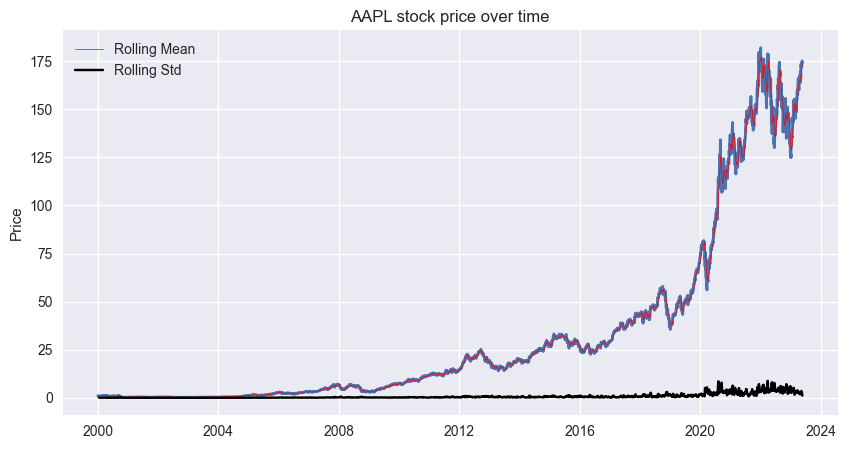

In [918]:
# Taking a look at the data

rolmean = data["Close"].rolling(12).mean()
rolstd = data["Close"].rolling(12).std()

plt.figure(figsize=(10,5))
plt.plot(data.index, data["Close"], linewidth = 2)
plt.title("AAPL stock price over time")
plt.ylabel("Price")
plt.plot(rolmean, color='red', label='Rolling Mean', linewidth = 0.5)
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.show()

As we can see the shape of this time series is very tipical for an evolution of a stock price, the series appear to be non-stationary hence the ARIMA model that is usually used for non stationarity should be fine. 

The non-stationarity in particular is a condition that affects time series whenever the mean and variance are not constant and depend on time $t$. As we can see from the plot above the mean clearly change and increase, even if there is a sort of constant but increasing variance overtime.

Stationarity also usually affect series that tend to *mean-revert* but as we know financial series regarding stocks do not mean revert overtime (otherwise it would be really simple to earn a lot of money in financial markets!). 

What appear to be a stationary series is instead the following daily log change series (log of difference in price and its lag(1)) since the mean and variance remains mostly constant. This means that returns tend to *mean-revert* since they have usually a constant variance and mean overtime and tend to be distributed randomly around a zero mean.

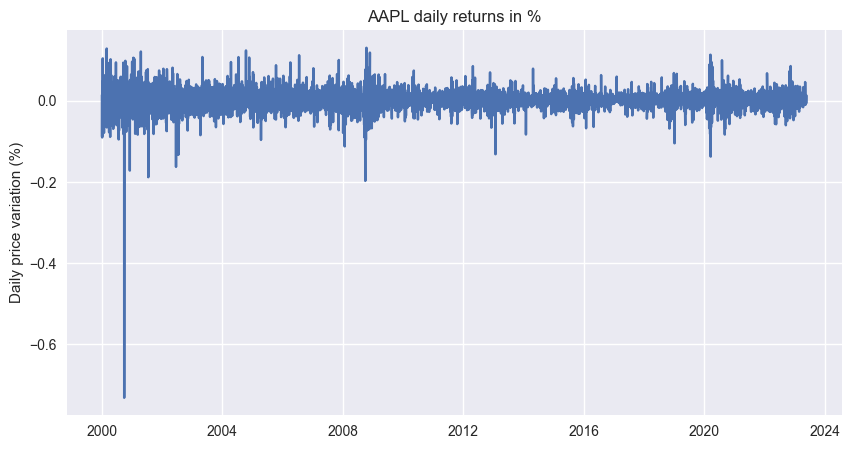

In [749]:
plt.figure(figsize=(10,5))
plt.plot(data.index, np.log(data['Close']/data['Close'].shift(1)))
plt.title("AAPL daily returns in %")
plt.ylabel("Daily price variation (%)")
plt.show()


To confirm our non-stationary hypotheses we may want to take also a look at correlation and in particular at cross correlation (autocorrelation) at different time-lags.

First we'll define a dataframe containing the closing price and the lags.

In [750]:
lags = pd.DataFrame(data['Close'])
for i in range(1, 10):
    lags[f'Lag {i}'] = data['Close'].shift(i)
lags.dropna(0, inplace=True)
lags.head()

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_55270/825019365.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.



,Close,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9
Date,,,,,,,,,,
2000-01-14,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.999442
2000-01-18,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179
2000-01-19,0.951451,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571
2000-01-20,1.013393,0.951451,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214
2000-01-21,0.993862,1.013393,0.951451,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393


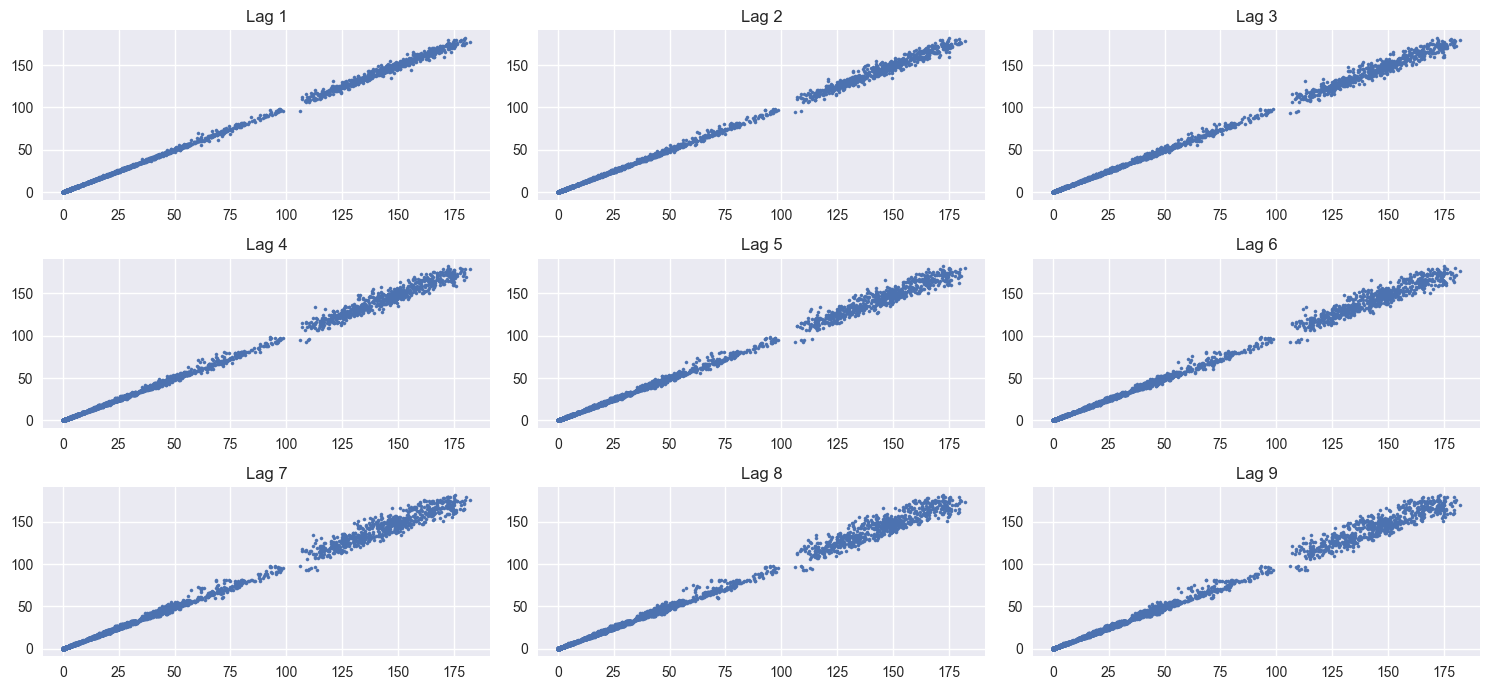

In [751]:
# Now let's look at the plots
fig, ax = plt.subplots(3, 3, figsize=(15, 7))
ax = ax.flatten()                         
for i in range(0,9):
    ax[i].scatter(lags['Close'], lags[f'Lag {i+1}'], s=5)
    ax[i].set_title(f'Lag {i+1}')
plt.tight_layout() # to avoid overlapping of subplots
plt.show()

From the plot above it really looks like the time series is non-stationarity. There is huge correlation between different lags and the original series, so ARIMA will be a really good model for predicting stock prices. 

We can also take a look at the autocorrelation function taken for all values of lag 20, that defines the correlation between the price and its value in another time period.

In [752]:
for i, val in enumerate(acf(data['Close'], nlags=20)):
    print(f"Autocorrelation at lag {i} is: {val}")

Autocorrelation at lag 0 is: 1.0
Autocorrelation at lag 1 is: 0.9988549155399105
Autocorrelation at lag 2 is: 0.9977270019800032
Autocorrelation at lag 3 is: 0.996617346202671
Autocorrelation at lag 4 is: 0.9955474979727161
Autocorrelation at lag 5 is: 0.9944875456002137
Autocorrelation at lag 6 is: 0.9934020496923872
Autocorrelation at lag 7 is: 0.9923179626491457
Autocorrelation at lag 8 is: 0.9911992102435643
Autocorrelation at lag 9 is: 0.9901151628960801
Autocorrelation at lag 10 is: 0.98901982573502
Autocorrelation at lag 11 is: 0.9879232136330256
Autocorrelation at lag 12 is: 0.986797587595533
Autocorrelation at lag 13 is: 0.9857693263093157
Autocorrelation at lag 14 is: 0.9847243146061408
Autocorrelation at lag 15 is: 0.9836558755659187
Autocorrelation at lag 16 is: 0.9825970693229885
Autocorrelation at lag 17 is: 0.9815241912913477
Autocorrelation at lag 18 is: 0.9804856605984787
Autocorrelation at lag 19 is: 0.9794486341186829
Autocorrelation at lag 20 is: 0.9784054340379775


We can confirm that ARIMA is going to be a good model to be applied to this type of data. Even if the autocorrelation is decreasing as the lag increase the correlation remain still really high. 

We may want also to statistically test the hypotheses of having non-stationarity in our data. For this we'll use the Augmented Dickey-Fuller test.

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level (0.05 by default) before the test and make conclusions on the hypothesis based on the resulting p-value.

- **Null Hypothesis**: The data is not stationary.

- **Alternative Hypothesis**: The data is stationary.

In [753]:
from statsmodels.tsa.stattools import adfuller

#Augmented Dickey–Fuller test:
print('Results of Augmented Dickey-Fuller Test:')
test = adfuller(data['Close'], autolag='AIC')
output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(output)

Results of Dickey Fuller Test:
Test Statistic                    2.141733
p-value                           0.998831
#Lags Used                       34.000000
Number of Observations Used    5849.000000
dtype: float64


As we can see the p-value is quite large, 0.99, so given that is greater than 0.05 we cannot reject the null hypotheses and hence confirm that our data is non-stationary and we'll need an ARIMA model and differencing to fit the data.

##### ARIMA Model Description

The acronym ARIMA stands for Auto-Regressive Integrated Moving Average. Lags of the stationarized series in the forecasting equation are called "autoregressive" terms, lags of the forecast errors are called "moving average" terms, and a time series which needs to be differenced to be made stationary is said to be an "integrated" version of a stationary series.

The standard ARIMA (Auto Regressive Integrated Moving Average) models expect as input parameters 3 arguments p, d, q:
- $p$ is the number of lag observations.
- $d$ is the degree of differencing.
- $q$ is the size/width of the moving average window.

The forecasting equation is constructed as follows.  First, let $y$ denote the dth difference of Y, which means:
- if $d=0$ , $y_t = Y_t$
- if $d=1$ , $y_t = Y_t - Y_{t-1}$
- if $d=2$ , $y_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) $

These $d$ transformations are needed to make the data stationary. In particular for this kind of series the differencing term will basically be the returns of the stock that as we explained before are stationary.

And in terms of $y$, the general forecasting equation is:

$$\hat{y_{t}} = \mu + \psi_1 y_{t-1} + \psi_2 y_{t-2} + ... + \psi_p y_{t-p} - \theta_1 e_{t-1} ... - \theta_1 e_{t-q}$$

where, 
- $\mu$ is the constant term
- $y_{t-1} ... y_{t-p} $ are the Auto Regressive terms, the lagged values of y (the stock price)
- $e_{t-1} ... e_{t-q}$ are the Moving Average terms, the lagged errors. This part of the time series is a stochastic component, a linear combination of $q$ lags of a white noise process. Usually $\theta_1$ is set to be equal to 1.

To identify the appropriate ARIMA model for Y, you begin by determining the order of differencing (d) needing to stationarize the series and remove the gross features of seasonality. Then, the stationarized series may still have autocorrelated errors, suggesting that some number of AR terms (p ≥ 1) and/or some number MA terms (q ≥ 1) are also needed in the forecasting equation.

Given that our series (and in general all time series of stocks price) is non-stationary and present very high autocorrelation, for sure we'll need $p≥0$ and $d≥0$.

##### Determine $d$

In order to first determine the degree of differencing we can use a function from the pmdarina library that will tell us the optimal degree of differencing to be used. 

In [754]:
from pmdarima.arima.utils import ndiffs

print('The optimal degree of differencing is d =', ndiffs(data['Close'], test='adf'))

The optimal degree of differencing is d = 1


We can also look at the std errors for each model using a difference order $d$, and use as a rule of thumb that the models with the smaller values of std error are the best.

In [910]:

for i in range(1, 5):
    model = ARIMA(data['Close'], order=(0,i,0))
    fit = model.fit()
    print(f"Std error for order difference of {i}:", fit.fittedvalues.std())

Std error for order difference of 1: 45.67299203614712
Std error for order difference of 2: 45.73518106008036
Std error for order difference of 3: 45.79087852775025
Std error for order difference of 4: 45.98161816528072


As we can see, $d = 1 \ and \ d=2$ exhibit the lower standard errors. So we could guess to pick one model or the other. 

From a theoretical point of view however we may want to prefer the model with d=1. As Robert Nau in "Statistical forecasting:
notes on regression and time series analysis" points out:

-  *"The model with two orders of differencing assumes that the trend in the series is time-varying, hence it considers the distant future to be much more uncertain than does the model with only one order of differencing."*   
- *The model with only one order of differencing assumes a constant average trend--it is essentially a fine-tuned random walk model with growth--and it therefore makes relatively conservative trend projections. It is also fairly optimistic about the accuracy with which it can forecast more than one period ahead. The model with two orders of differencing assumes a time-varying local trend--it is essentially a linear exponential smoothing model--and its trend projections are somewhat more more fickle.*

For this reasons, we may want to prefer a value of $d=1$ as it was also suggested by the pmdarima function.

##### Determine $p$

We can find $p$, the number of lags of the AR term to be included in the model, by inspecting Autocorrelation Plot (ACF), that can be used to draw a correlation between the time series (the first order difference series) and its lag while the contribution from intermediate lags can be ignored. This plotting will let us know about the lags that are not required in the autoregression part. 

In order to do this, we first calculate the first difference (daily changes in the stock price) and then plot the autocorrelation function for different time lags.

(-0.15, 1.0)

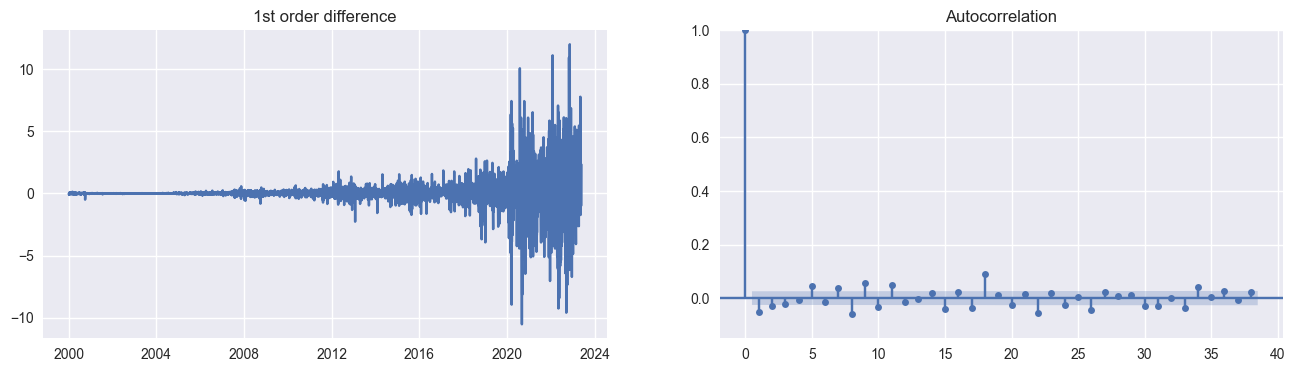

In [889]:
from statsmodels.graphics.tsaplots import plot_pacf

diff = data['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("1st order difference")
plot_acf(diff, ax2)
ax2.set_ylim(-0.15, 1)

As we can see there $p = 1$ is amongst the first five lags, the most significant value out of the limit. After this the autocorrelations decrease significatively even if after lag 5 there are other sporadic spikes. For this reason we decide to select a value of $p=1$.

##### Determine $q$

We can find $q$, the number of lags of the MA term to be included in the model, by inspecting Partial Autocorrelation plot (PACF), that will suggest us how much moving average is required to remove the autocorrelation from the stationary time series. 

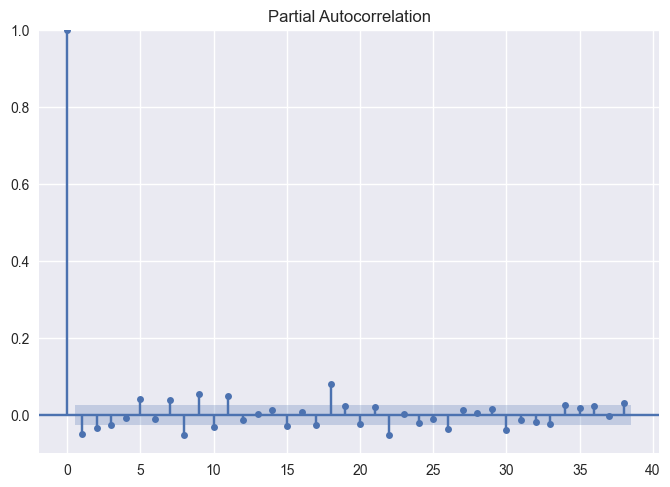

In [759]:
plot_pacf(data['Close'].diff().dropna())
plt.ylim(-0.1, 1);

As we can see the after the firs lag there is drop in the significance and consistency of the following autocorrelations. This hence suggest that $q=1$ is a good guess for our model.

##### Train-Test split

In [953]:
#split data into train and training set
train_data, test_data = data['Close'][:int(len(data)*0.9)], data['Close'][int(len(data)*0.9):]

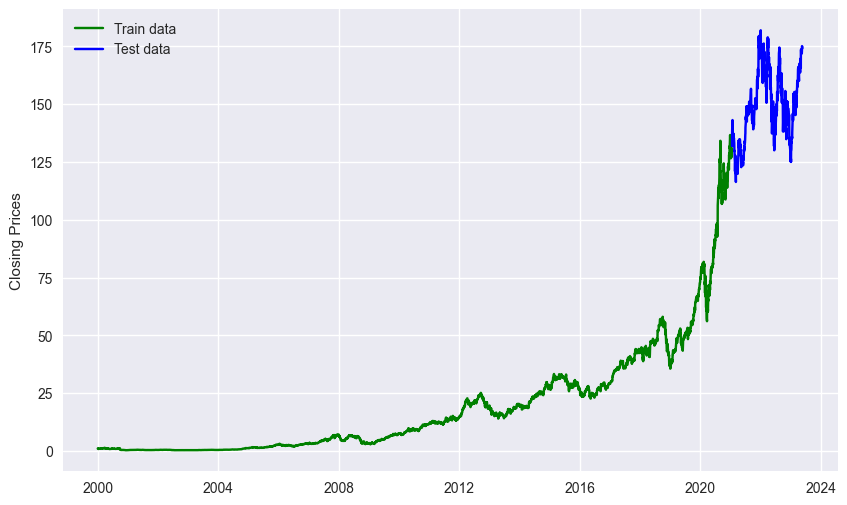

In [954]:
# Plot the train-test division
plt.figure(figsize=(10,6))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

##### Auto-ARIMA 

Even if examining the autocorrelation plots and partial autocorrelation plots is a good way for picking values for $p$ and $q$, there is a package called ``pmarima`` that embeed a function that automatically detect the best parameters for the ARIMA model. This will be useful for the implementation of this algorithm in the Streamlit web app that'll allow to the script to automatically detect the best parameters without analyzing all this informations individually.

The ``auto_arima`` function identify the optimal parameters for an ARIMA model, and returns a fitted ARIMA model.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10825.290, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10734.939, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10740.322, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10830.007, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10734.029, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10735.993, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10736.016, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10734.179, Time=0.60 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10737.965, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=10740.340, Time=0.15 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 4.059 seconds


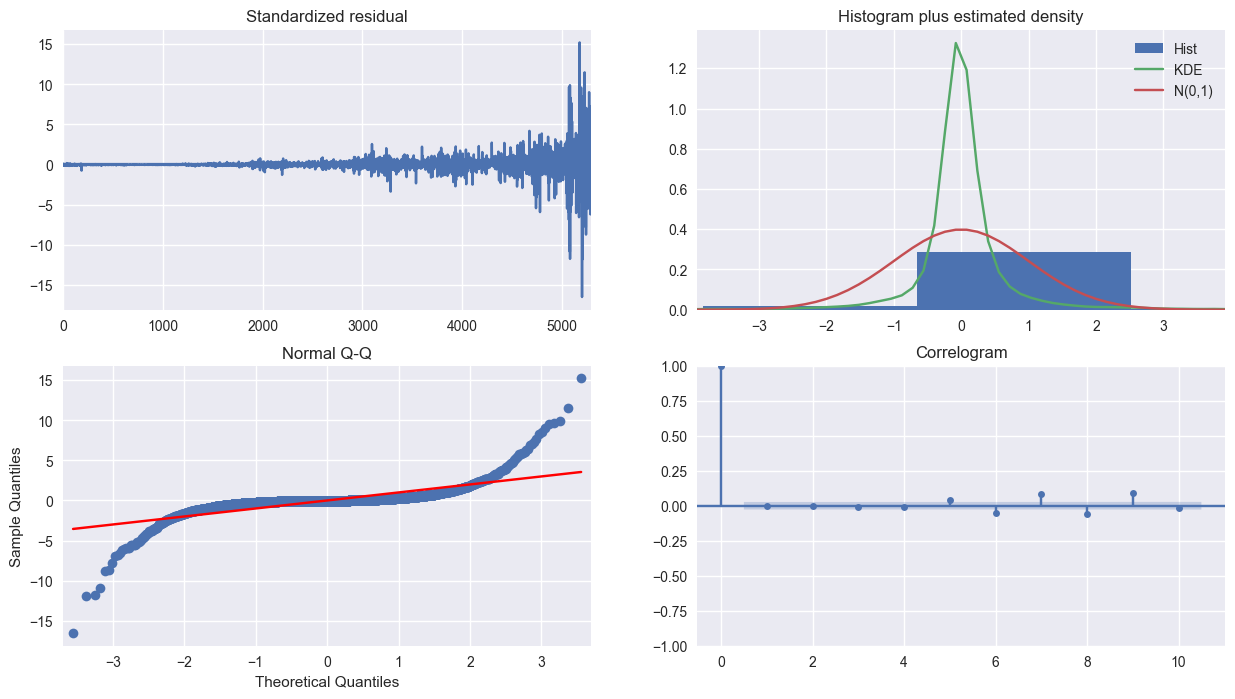

In [1036]:
# AUTO ARIMA MODEL identification
model_autoARIMA = pm.auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) #use the stepwise algorithm
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [972]:
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5295
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -5363.014
Date:                Tue, 23 May 2023   AIC                          10734.029
Time:                        16:27:42   BIC                          10760.326
Sample:                             0   HQIC                         10743.219
                               - 5295                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0265      0.009      2.869      0.004       0.008       0.045
ar.L1         -0.1284      0.004    -36.041      0.000      -0.135      -0.121
ar.L2          0.0235      0.003      7.757      0.0

In [948]:
forecast_period = 1000
forecast, confint = model_autoARIMA.predict(n_periods=forecast_period, return_conf_int=True)

In [949]:
# First, we add the number of days to obtain the last date for the period using timedelta, then we convert the datetime object into a string
# with format Y-m-d
end_period = (train_data.index[-1] + timedelta(days=forecast_period)).strftime('%Y-%m-%d') 

market_year = mcal.get_calendar('Financial_Markets_US') #using get_calendar we obtain the yearly calendar for US markets
cal = market_year.schedule(start_date=train_data.index[-1], end_date=end_period) #now we oobtain the full schedule

#And finally convert the schedule into a daterange that will be the dateindex of our forecasted series.

forecast_dates = mcal.date_range(cal, frequency='1D')

In [980]:
fig = go.Figure([go.Scatter( #add the Upper Bound of the confidence interval
                x=forecast_dates, 
                y=confint[:,1], 
                marker=dict(color="lightgrey"),
                name = 'Upper bound CI',
                showlegend=False
                ),
                go.Scatter( #add the lower Bound of the confidence interval
                x=forecast_dates, # x, then x reversed
                y=confint[:,0], # upper, then lower reversed
                marker=dict(color="lightgrey"),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)', #color to fill in the area
                fill='tonexty', #type of filling
                name = 'Upper bound CI',
                showlegend=False
                ), 
                go.Scatter( #add the Prediction
                    x=forecast_dates, y=forecast, line=dict(color='orange'),
                    mode='lines', name='Prediction')
            ])
fig.add_trace(go.Scatter(x=train_data.index, y=train_data, name='Train data')) #Test series
fig.add_trace(go.Scatter(x=test_data.index, y=test_data, name='Actual stock price (Test)', marker=dict(color="red"))) #Train serie
fig.update_layout(
    title="Price prediction for AAPL", 
    yaxis_title="Price ($)", 
)
fig.update_xaxes(nticks = 25)

fig.show()

#### Withouth train/test:

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17693.329, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17680.006, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17678.911, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17695.634, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17673.927, Time=1.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17674.917, Time=3.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17675.027, Time=2.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17674.403, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17675.466, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17677.433, Time=1.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17677.242, Time=0.43 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 11.040 seconds


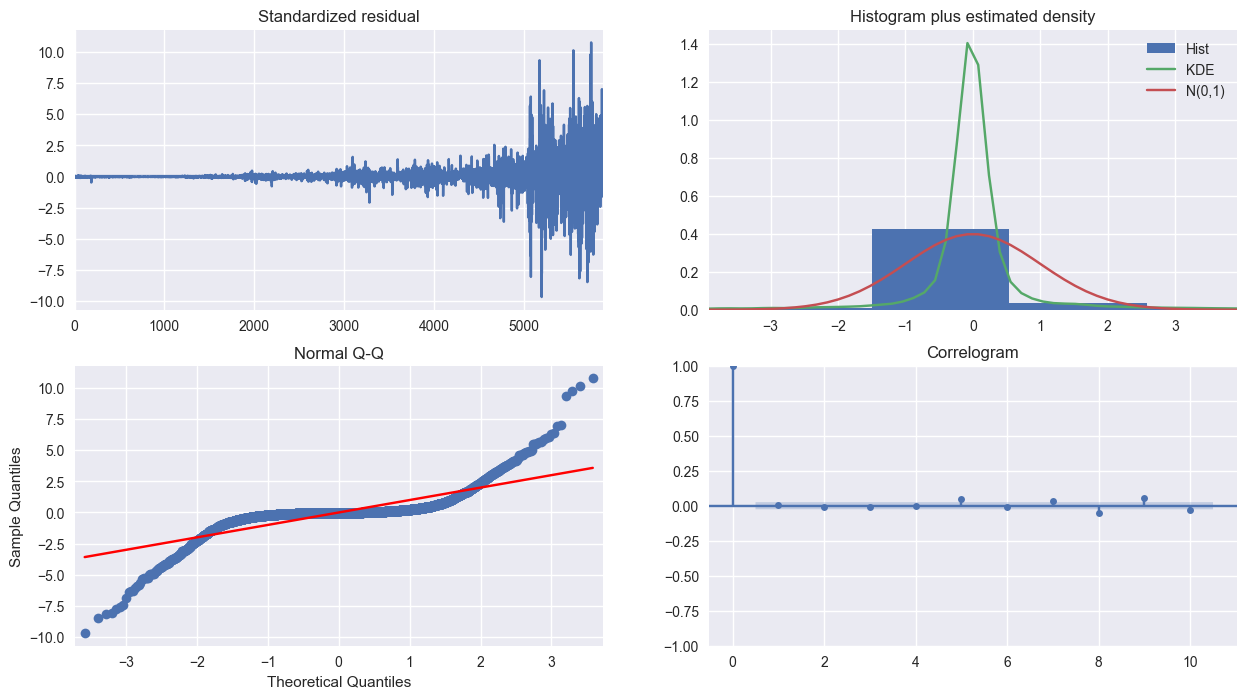

In [981]:
# AUTO ARIMA MODEL identification
model_autoARIMA = pm.auto_arima(data['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True) #use the stepwise algorithm
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [982]:
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5884
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -8832.964
Date:                Tue, 23 May 2023   AIC                          17673.927
Time:                        16:36:07   BIC                          17700.646
Sample:                             0   HQIC                         17683.215
                               - 5884                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0168      0.008      2.148      0.032       0.001       0.032
ar.L1          0.4277      0.060      7.137      0.000       0.310       0.545
ma.L1         -0.4847      0.059     -8.281      0.0

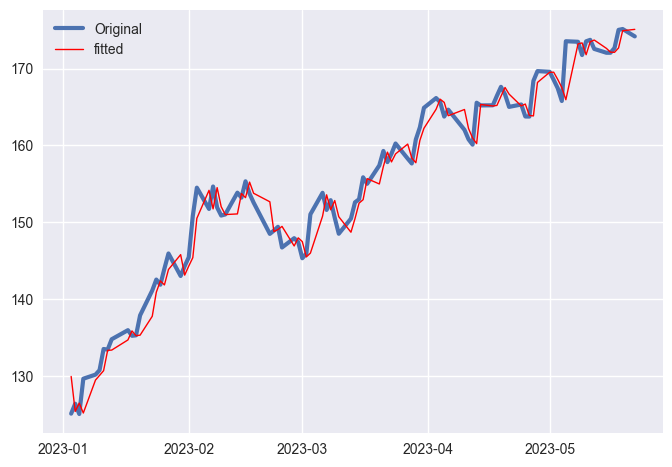

In [1029]:
#plot from 2023 to see how the model is fitting
plt.plot(data['Close']['2023':], linewidth=3, label='Original')
plt.plot(model_autoARIMA.fittedvalues()['2023':], color = 'red', linewidth = 1, label='fitted')
plt.legend()

In [1030]:
forecast_period = 300

prediction, confint = model_autoARIMA.predict(n_periods=forecast_period, return_conf_int=True)
prediction

5884    174.250036
5885    174.288285
5886    174.321491
5887    174.352541
5888    174.382669
           ...    
6179    182.949867
6180    182.979306
6181    183.008745
6182    183.038183
6183    183.067622
Length: 300, dtype: float64

Now we'll create a series for the period of our interest for predicting the price, and convert this series into the format of a Financial Market year (we'll take US as a reference), since there are only 252 trading days in a solar year.

For this we'll need to libraries, pandas_market_calendars that allow us to extrapolate future market trading days (for our forecasting period of interest) and datetime to manipulate date objects.

In [1031]:
import pandas_market_calendars as mcal
from datetime import datetime, timedelta

today = datetime.today() #get today's date

# First, we add the number of days to obtain the last date for the period using timedelta, then we convert the datetime object into a string
# with format Y-m-d
end_period = (today + timedelta(days=forecast_period)).strftime('%Y-%m-%d') 

market_year = mcal.get_calendar('Financial_Markets_US') #using get_calendar we obtain the yearly calendar for US markets
cal = market_year.schedule(start_date=today.strftime('%Y-%m-%d'), end_date=end_period) #now we oobtain the full schedule

#And finally convert the schedule into a daterange that will be the dateindex of our forecasted series.

forecast_dates = mcal.date_range(cal, frequency='1D') 

In [1032]:
fig = go.Figure([go.Scatter( #add the Upper Bound of the confidence interval
                x=forecast_dates, 
                y=confint[:,1], 
                marker=dict(color="lightgrey"),
                name = 'Upper bound CI',
                showlegend=False
                ),
                go.Scatter( #add the lower Bound of the confidence interval
                x=forecast_dates, # x, then x reversed
                y=confint[:,0], # upper, then lower reversed
                marker=dict(color="lightgrey"),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)', #color to fill in the area
                fill='tonexty', #type of filling
                name = 'Upper bound CI',
                showlegend=False
                ), 
                go.Scatter( #add the Prediction
                    x=forecast_dates, y=prediction, line=dict(color='orange'),
                    mode='lines', name='Prediction')
            ])
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], name='Original series')) #This is the original series
fig.update_layout(
    title="Price prediction for AAPL", 
    yaxis_title="Price ($)", 
)
fig.update_xaxes(nticks = 25)

fig.show()

#### Write function and code for plotting ARIMA prediction in the Dashboard 

In [ ]:
def ARIMA_forecast(data, forecast_period):    

    model_autoARIMA = pm.auto_arima(data['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

    
    parameters = model_autoARIMA.get_params()['order']
    parameters = {'p, number of Autoregressive terms': parameters[0], 
                    'd, difference order': parameters[1], 
                    'q, number of Moving Average terms' : parameters[2]}


    predicted, confint = model_autoARIMA.predict(n_periods=forecast_period, return_conf_int=True)

    # Calculate the dates of the days in for the forecasted period (market year)
    today = datetime.today() #get today's date
    end_period = (today + timedelta(days=forecast_period)).strftime('%Y-%m-%d') 
    market_year = mcal.get_calendar('Financial_Markets_US') #using get_calendar we obtain the yearly calendar for US markets
    cal = market_year.schedule(start_date=today.strftime('%Y-%m-%d'), end_date=end_period) #now we oobtain the full schedule
    #And finally convert the schedule into a daterange that will be the dateindex of our forecasted series.
    forecast_dates = mcal.date_range(cal, frequency='1D') 

    return forecast_dates, confint, predicted

In [ ]:
fig = go.Figure([go.Scatter( #add the Upper Bound of the confidence interval
                x=forecast_dates, 
                y=confint[:,1], 
                marker=dict(color="lightgrey"),
                name = 'Upper bound CI',
                showlegend=False
                ),
                go.Scatter( #add the lower Bound of the confidence interval
                x=forecast_dates, # x, then x reversed
                y=confint[:,0], # upper, then lower reversed
                marker=dict(color="lightgrey"),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)', #color to fill in the area
                fill='tonexty', #type of filling
                name = 'Upper bound CI',
                showlegend=False
                ), 
                go.Scatter( #add the Prediction
                    x=forecast_dates, y=predicted, line=dict(color='orange'),
                    mode='lines', name='Prediction')
            ])
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], name='Original series')) #This is the original series
fig.update_layout(
    title="Price prediction for AAPL", 
    yaxis_title="Price ($)", 
)
fig.update_xaxes(nticks = 25)

fig.show()

### 2.1.2 XGBOOST Models

In [48]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [35]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.849468,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.777850,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.789232,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.720933,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.755083,460734400


In [36]:
df = data.iloc[:-2, 3:4]
df.head()

,Close
Date,
2000-01-03,0.999442
2000-01-04,0.915179
2000-01-05,0.928571
2000-01-06,0.848214
2000-01-07,0.888393


Since we want to predict the future returns, we'll ad a column referring the the closing price at t+1, and we'll use this column as the target variable. 

In [37]:
df['Past_Ret'] = np.log(df['Close']/df['Close'].shift(1))
df['Diff_1'] = df['Close'].diff()
df['Diff_2'] = df['Close'].diff().diff()
df['Future_ret'] = df['Past_Ret'].shift(-1)
df

,Close,Past_Ret,Diff_1,Diff_2,Future_ret
Date,,,,,
2000-01-03,0.999442,NaN,NaN,NaN,-0.088077
2000-01-04,0.915179,-0.088077,-0.084263,NaN,0.014527
2000-01-05,0.928571,0.014527,0.013392,0.097655,-0.090514
2000-01-06,0.848214,-0.090514,-0.080357,-0.093749,0.046281
2000-01-07,0.888393,0.046281,0.040179,0.120536,-0.017744
...,...,...,...,...,...
2023-05-24,171.839996,0.001631,0.279999,2.919998,0.006670
2023-05-25,172.990005,0.006670,1.150009,0.870010,0.014006
2023-05-26,175.429993,0.014006,2.439987,1.289978,0.010603


In [38]:
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week.astype(int)
df.head()

,Close,Past_Ret,Diff_1,Diff_2,Future_ret,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,
2000-01-03,0.999442,NaN,NaN,NaN,-0.088077,0,1,1,2000,3,3,1
2000-01-04,0.915179,-0.088077,-0.084263,NaN,0.014527,1,1,1,2000,4,4,1
2000-01-05,0.928571,0.014527,0.013392,0.097655,-0.090514,2,1,1,2000,5,5,1
2000-01-06,0.848214,-0.090514,-0.080357,-0.093749,0.046281,3,1,1,2000,6,6,1
2000-01-07,0.888393,0.046281,0.040179,0.120536,-0.017744,4,1,1,2000,7,7,1


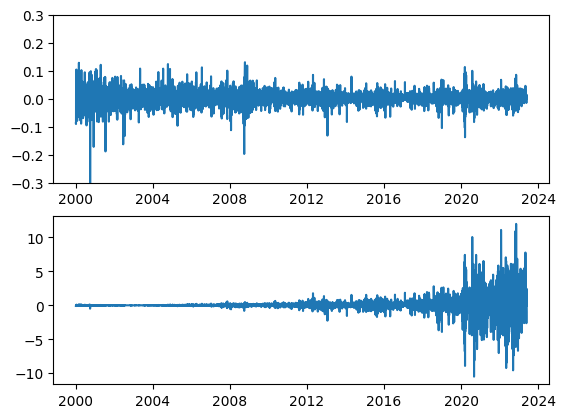

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(df['Past_Ret'])
ax1.set_ylim(-0.3, 0.3)
ax2.plot(df['Diff_1'])

In [40]:
df.dropna(inplace=True)
df.head()

,Close,Past_Ret,Diff_1,Diff_2,Future_ret,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,
2000-01-05,0.928571,0.014527,0.013392,0.097655,-0.090514,2,1,1,2000,5,5,1
2000-01-06,0.848214,-0.090514,-0.080357,-0.093749,0.046281,3,1,1,2000,6,6,1
2000-01-07,0.888393,0.046281,0.040179,0.120536,-0.017744,4,1,1,2000,7,7,1
2000-01-10,0.872768,-0.017744,-0.015625,-0.055804,-0.052506,0,1,1,2000,10,10,2
2000-01-11,0.828125,-0.052506,-0.044643,-0.029018,-0.061846,1,1,1,2000,11,11,2


In [41]:
test_idx  = int(df.shape[0] * (1-0.1)) #index for the test set

# Create the two sets dataframes (the copy function will make a copy of the original df indices and only the subset data

train_df  = df.iloc[:test_idx+1, :].copy()
test_df   = df.iloc[test_idx:, :].copy()

In [42]:
#Split target and features 
xs = list(range(0,4)) + list(range(5, 12))

y_train = train_df['Future_ret'].copy()
X_train = train_df.iloc[:, xs].copy()

y_test  = test_df['Future_ret'].copy()
X_test  = test_df.iloc[:, xs].copy()

X_train.head()

,Close,Past_Ret,Diff_1,Diff_2,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,
2000-01-05,0.928571,0.014527,0.013392,0.097655,2,1,1,2000,5,5,1
2000-01-06,0.848214,-0.090514,-0.080357,-0.093749,3,1,1,2000,6,6,1
2000-01-07,0.888393,0.046281,0.040179,0.120536,4,1,1,2000,7,7,1
2000-01-10,0.872768,-0.017744,-0.015625,-0.055804,0,1,1,2000,10,10,2
2000-01-11,0.828125,-0.052506,-0.044643,-0.029018,1,1,1,2000,11,11,2


In [1713]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.01,
                       gamma=0.001
                       )
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[17:42:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49479	validation_1-rmse:0.49484
[100]	validation_0-rmse:0.18282	validation_1-rmse:0.18225
[200]	validation_0-rmse:0.07101	validation_1-rmse:0.07033
[300]	validation_0-rmse:0.03447	validation_1-rmse:0.03180
[400]	validation_0-rmse:0.02541	validation_1-rmse:0.02083
[500]	validation_0-rmse:0.02356	validation_1-rmse:0.02022
[520]	validation_0-rmse:0.02340	validation_1-rmse:0.02031


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In order to find the best model parameters we are going to perform a grid search. 

First we'll define as a dictionary an initial possible list of values for each parameters. 
Then we are going to create and evaluation set composed by the training and the validation set. 
After that, the model will be initalized and then the GridSearchCV function will peform a Grid Search and find the best model parameters under our objective function of minimizing the squared error. 

In [53]:
# Let's try to find the best parameters with GridSearchCV:

parameters = {
    'n_estimators' : [200, 400, 600, 800, 1000],
    'learning_rate' : [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth' : [5, 8, 10, 12, 15],
    'gamma' : [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set=[(X_train, y_train), (X_test, y_test)]
model = xgb.XGBRegressor(booster='gbtree', early_stopping_rounds=100, eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[10:59:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[10:59:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[10:59:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[10:59:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[10:59:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[10:59:45] WARNING: /Users/runner/w

KeyboardInterrupt: 

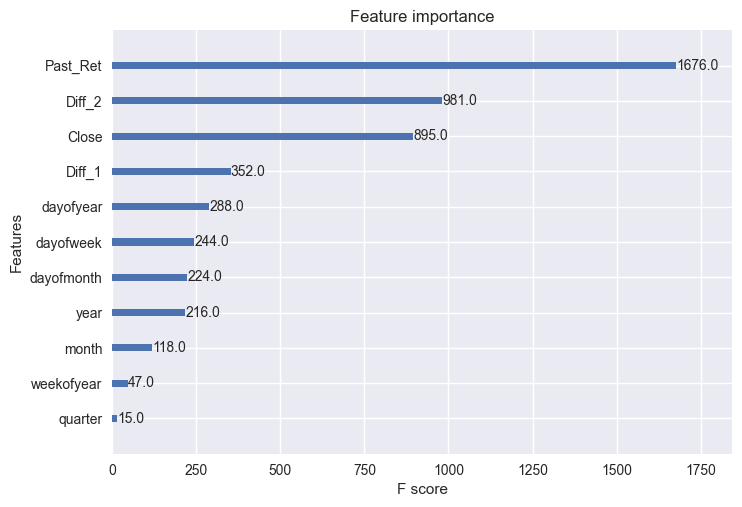

In [1714]:
plot_importance(model);

As we can see from the above plot, past returns, second order difference and the last closing pricing are the most important determinants for predicting the future stock price. 

One important feature to mention is the day of the week, that appear to be one of the most important features. As we can see from the image below, there are weekdays that have on average higher returns. 

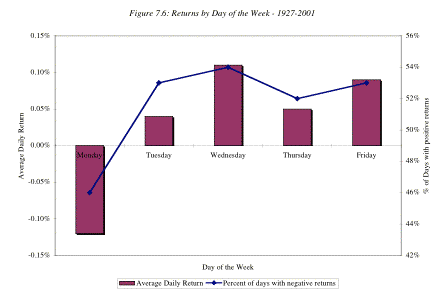

In [1715]:
test_prediction = model.predict(X_test)
pred_Close = np.array(X_test.iloc[0, 0]) #First element has not to be predicted, is the last element of the training set

for i in range(0, len(test_df)-1): #run until the second-last that'll allow the prediction for the last one

        pred_Close = np.append(pred_Close, (X_test.iloc[i, 0] * (1+test_prediction[i])))

# Add prediction of the test set to the test dataframe
test_df['Pred_Close'] = pred_Close
test_df

,Close,Past_Ret,Diff_1,Diff_2,Future_ret,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Pred_Close
Date,,,,,,,,,,,,,
2021-01-19,127.830002,0.005412,0.690002,2.460007,0.032328,1,1,1,2021,19,19,3,127.830002
2021-01-20,132.029999,0.032328,4.199997,3.509995,0.036002,2,1,1,2021,20,20,3,128.648919
2021-01-21,136.869995,0.036002,4.839996,0.639999,0.015946,3,1,1,2021,21,21,3,131.784835
2021-01-22,139.070007,0.015946,2.200012,-2.639984,0.027308,4,1,1,2021,22,22,3,136.541854
2021-01-25,142.919998,0.027308,3.849991,1.649979,0.001678,0,1,1,2021,25,25,4,138.731503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15,172.070007,-0.002902,-0.500000,0.679993,0.000000,0,2,5,2023,135,15,20,172.222286
2023-05-16,172.070007,0.000000,0.000000,0.500000,0.003597,1,2,5,2023,136,16,20,171.924285
2023-05-17,172.690002,0.003597,0.619995,0.619995,0.013574,2,2,5,2023,137,17,20,171.727815


In [1716]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['Close'], name='Train', marker_color='LightSkyBlue'), row=1, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['Close'], name='Test', marker_color='MediumPurple'), row=1, col=1)
fig.add_trace(go.Scatter(x=test_df.index,  y=test_df['Pred_Close'],  name='Predicted', marker_color='red'), row=1, col=1)

fig.add_trace(go.Scatter(x=train_df.index[5030:], y=train_df['Close']['2020':], name='Train', marker_color='LightSkyBlue'), row=2, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['Close'], name='Test', marker_color='red'), row=2, col=1)
fig.add_trace(go.Scatter(x=test_df.index,  y=test_df['Pred_Close'],  name='Predicted'), row=2, col=1)

fig.update_layout(height = 800)

fig.show()

As we can see from the plot above, our model seems to predict really well the test data. 

Let's see now an out-of sample prediction.

#### Out of sample prediction

In [1717]:
# Pick a value for the forecast (next 300 days)
future = 300

As we did before in the ARIMA part, we need to obtain the calendar for the next 300 days in order to convert the index of the forecasted data into a datetime index that can be used for display and pot purposes.

In [1718]:
today = X_test.index[-1] #get last day of the training set

# First, we add the number of days to obtain the last date for the period using timedelta, then we convert the datetime object into a string
# with format Y-m-d
end_period = (today + timedelta(days=future)).strftime('%Y-%m-%d')  #shift to the end period by 300 days

market_year = mcal.get_calendar('Financial_Markets_US') #using get_calendar we obtain the yearly calendar for US markets
cal = market_year.schedule(start_date=today.strftime('%Y-%m-%d'), end_date=end_period) #now we oobtain the full schedule

#And finally convert the schedule into a daterange that will be the dateindex of our forecasted series.

dates = mcal.date_range(cal, frequency='1D') 

Now we can proceed creating a dataframe that'll store the features to be used in the prediction and has as the first observation the last observation from the test set (that should be the observation from today).

In [1719]:
# oos stands for out of sample

X_oos = X_test.iloc[-2:-1, :] #pick last observation from the test sample
X_oos

,Close,Past_Ret,Diff_1,Diff_2,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,
2023-05-18,175.050003,0.013574,2.360001,1.740005,3,2,5,2023,138,18,20


Now using the model estimated before we'll predict the return of this observation that will allow us to forecast the close price of the next observation (starting from the price of today).

We can infact estimate Close prices ($CP$) at time $t$ with the following formula:
$$CP_{t+1} = CP_t * (1 + r_{t, t+1})$$ 

where, 

- $r_{t, t+1}$ is the return predicted using the XGboost model

Hence the forecasted return between /05/2023 and /05/2023 will be:

In [1720]:
# Predict the first return, between today and tomorrow.

pred_oos = model.predict(X_oos.iloc[0:1, :]) 
pred_oos

array([-0.0025646], dtype=float32)

Now we need to obtain features from  dates, the series containing the datetime index for the future period in which we want to predict the stock price.

In [1721]:
dayofweek= dates.dayofweek
quarter = dates.quarter
month = dates.month
year = dates.year
dayofyear = dates.dayofyear
day = dates.day
weekofyear = dates.isocalendar().week.astype(int)

With the next for loop, the code will run for all the observation in the range of the future period we want to predict. 
- For each day we'll create the Close price as explained before, $CP_{t+1} = CP_t * (1 + r_{t, t+1})$. 
- the Log_returns of a specific day will be the predicted returns of the previous day
- The first difference order will be calculated as the $CP_{t} -  CP_{t-1}$, where $CP_{t-1}$ is the Close price of the previous day
- The second difference order is calculated as the current first difference order minus the first difference order of the previous day, so: $d^1 _{t} - d^1 _{t-1}$
- the rest of the seasonal features (dayofweek, quarter ...) are taken from each relative index created above (at time t).

Lastly, after assigning all the features to an observation (a specific day) we can predict the target variable Future_returns, that we'll be fundamental in the following reiteration of the loop for calculating the Close Price and the rest of the features. 

One important thing to highlight, is that now the `Close Price` that will be calculated is the *actual prediction* for the Price of that specific day, that specific observation. 

In [1722]:
for i in range(1, len(dayofweek)):

    # Loc will insert a new row of features (for a specific day) at the bottom of the dataframe
    X_oos.loc[i] = [
        (X_oos.iloc[i-1, 0]) * (1+pred_oos[i-1]), # Close price
        pred_oos[i-1], #Returns (predicted)
        ((X_oos.iloc[i-1, 0]) * (1+pred_oos[i-1])) - (X_oos.iloc[i-1, 0]), #first order difference
        (((X_oos.iloc[i-1, 0]) * (1+pred_oos[i-1])) - (X_oos.iloc[i-1, 0])) - X_oos.iloc[i-1, 2],#second order difference
        int(dayofweek[i]), #take same daysofweek as X_test
        int(quarter[i]), #take same quarter as X_test
        int(month[i]), #take same month as X_test
        int(year[i]), #take same year as X_test
        int(dayofyear[i]), #take same dayofyear as X_test
        int(day[i]), #take same dayofmonth as X_test
        int(weekofyear[i]) #take same weekofyear as X_test
    ]

    # Now predict the actual return based on the set of features inserted above. And append it to the array containing the first prediction.
    pred_oos = np.append(pred_oos, [model.predict(X_oos.iloc[i:(i+1), :])])
    

# After running the whole loop, this will update the dataframe index with the dates calendar obtained before.
X_oos.set_index(dates, inplace=True) 
X_oos

,Close,Past_Ret,Diff_1,Diff_2,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2023-05-19 21:30:00+00:00,175.050003,0.013574,2.360001,1.740005,3.0,2.0,5.0,2023.0,138.0,18.0,20.0
2023-05-22 21:30:00+00:00,174.601069,-0.002565,-0.448934,-2.808934,0.0,2.0,5.0,2023.0,142.0,22.0,21.0
2023-05-23 21:30:00+00:00,174.294812,-0.001754,-0.306257,0.142677,1.0,2.0,5.0,2023.0,143.0,23.0,21.0
2023-05-24 21:30:00+00:00,173.994139,-0.001725,-0.300674,0.005583,2.0,2.0,5.0,2023.0,144.0,24.0,21.0
2023-05-25 21:30:00+00:00,173.693984,-0.001725,-0.300155,0.000519,3.0,2.0,5.0,2023.0,145.0,25.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-08 22:30:00+00:00,150.627809,-0.002483,-0.374986,-0.052824,4.0,1.0,3.0,2024.0,68.0,8.0,10.0
2024-03-11 21:30:00+00:00,150.415996,-0.001406,-0.211813,0.163173,0.0,1.0,3.0,2024.0,71.0,11.0,11.0
2024-03-12 21:30:00+00:00,150.116867,-0.001989,-0.299129,-0.087316,1.0,1.0,3.0,2024.0,72.0,12.0,11.0
2024-03-13 21:30:00+00:00,149.797277,-0.002129,-0.319590,-0.020461,2.0,1.0,3.0,2024.0,73.0,13.0,11.0


As we can see we have created a new dataframe containing the prediction for the selected future period, in which some features are kwown in advance (mainly the seasonal feature) but some other features are forecasted based on the prediction of the XGboost model.

In [1723]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['Close'], name='Train'))
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['Close'], name='Test'))
fig.add_trace(go.Scatter(x=X_oos.index,  y=X_oos['Close'],  name='Out of sample prediction'))
fig.add_trace(go.Scatter(x=X_oos.index,  y=X_oos['Close'],  name='Test prediction'))
fig.show()

As we can see, the algortihm carried out a relatively realistic prediction, and it looks like including a set of seasonal features helped to catch possible sources of variability in the returns (and consequently in the price).

#### Write function and code for plotting XGBOOST prediction in the Dashboard 

In [ ]:
def XGBOOST_forecast(data, forecast_period):  

    df = data.iloc[:, 3:4]

    ### Create set of features

    df['Past_Ret'] = np.log(df['Close']/df['Close'].shift(1))
    df['Diff_1'] = df['Close'].diff()
    df['Diff_2'] = df['Close'].diff().diff()
    df['Future_ret'] = df['Past_Ret'].shift(-1)

    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)

    df.dropna(inplace=True)

    ### Train/test split  
    test_idx  = int(df.shape[0] * (1-0.1)) #index for the test set
    train_df  = df.iloc[:test_idx+1, :].copy()
    test_df   = df.iloc[test_idx:, :].copy()

    #Split target and features 
    xs = list(range(0,4)) + list(range(5, 12))

    y_train = train_df['Future_ret'].copy()
    X_train = train_df.iloc[:, xs].copy()

    y_test  = test_df['Future_ret'].copy()
    X_test  = test_df.iloc[:, xs].copy()

    ### Perform XGBOOST
    model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=5,
                        learning_rate=0.01,
                        gamma=0.001)
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
            
    # Calculate the dates of the days in for the forecasted period (market year)
    today = X_test.index[-1] #get last day of the training set
    end_period = (today + timedelta(days=forecast_period)).strftime('%Y-%m-%d') 
    market_year = mcal.get_calendar('Financial_Markets_US') #using get_calendar we obtain the yearly calendar for US markets
    cal = market_year.schedule(start_date=today.strftime('%Y-%m-%d'), end_date=end_period) #now we obtain the full schedule
    #And finally convert the schedule into a daterange that will be the dateindex of our forecasted series.
    forecast_dates = mcal.date_range(cal, frequency='1D') 
    
    ###
    X_oos = X_test.iloc[-2:-1, :] #pick last observation from the test sample
    pred_oos = model.predict(X_oos.iloc[0:1, :])  #predict first return

    dayofweek= forecast_dates.dayofweek
    quarter = forecast_dates.quarter
    month = forecast_dates.month
    year = forecast_dates.year
    dayofyear = forecast_dates.dayofyear
    day = forecast_dates.day
    weekofyear = forecast_dates.isocalendar().week.astype(int)

    
    for i in range(1, len(dayofweek)):
        
        X_oos.loc[i] = [
                (X_oos.iloc[i-1, 0]) * (1+pred_oos[i-1]), # Close price
                pred_oos[i-1], #Returns (predicted)
                ((X_oos.iloc[i-1, 0]) * (1+pred_oos[i-1])) - (X_oos.iloc[i-1, 0]), #first order difference
                (((X_oos.iloc[i-1, 0]) * (1+pred_oos[i-1])) - (X_oos.iloc[i-1, 0])) - X_oos.iloc[i-1, 2],#second order difference
                dayofweek[i], #take same daysofweek as X_test
                quarter[i], #take same quarter as X_test
                month[i], #take same month as X_test
                year[i], #take same year as X_test
                dayofyear[i], #take same dayofyear as X_test
                day[i], #take same dayofmonth as X_test
                weekofyear[i] #take same weekofyear as X_test
        ]
        # Now predict the actual return based on the set of features inserted above. And append it to the array containing the first prediction.
        pred_oos = np.append(pred_oos, [model.predict(X_oos.iloc[i:(i+1), :])])


    X_oos.set_index(dates, inplace=True)        
    
    return X_oos, train_df, test_df

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['Close'], name='Train'))
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['Close'], name='Test'))
fig.add_trace(go.Scatter(x=X_oos.index,  y=X_oos['Close'],  name='Out of sample prediction'))
fig.update_layout(height = 600)
fig.show()

### 2.2 PortFolio Optimization

In [ ]:
#Create a function to minimize, to find the portfolio with the highest sharpe Ratio, the highest risk-adjusted return

def sharpe_ptf(W, returns):
    
    ptf_risk = W.dot(returns.cov()).dot(W) ** 0.5 
    #calculating the portfolio risk, the portfolio standard deviation. 

    SR = W.dot(returns.mean()) / ptf_risk

    return -SR  #return negative value of the sharpe ratio in order to minimize it. 

In [ ]:
sharpe_ptf(weights, ret_df)

Explain how minimize function of scipy works

In [ ]:
#Is the equal weighted portfolio the best choice? 

#define the constraint, the sum of the weights of portfolio assets has to be equal to 0
const = ({'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})
# constraint is a dictionary
# type is the type of the constraint, in this case is an equality (eq)
# fun is the function defining the constraint, you are adding all the elements of the list 'weights'
# since it's an equality, you can write np.sum(x) = 1 (the constraint), as np.sum(x) - 1 and tell python is the function to solve the equality

#now minimize
results = minimize(sharpe_ptf, weights, ret_df, constraints = const)
results

# weights are the initial guess of the parameter to optimize
# the const is defined as a dictionary, 

Now we are going to define a function to calculate the optimal weights for the portfolio assets by maximizing the Sharpe Ratio calculated with the sharpe_ptf function.

In [ ]:
def ptf_optimization(stocks, commodities, start, short):

    assets = stocks + commodities
    tickers = assets
    df = yf.download(tickers, start = start)['Adj Close']

    ret_df = np.log(df/df.shift(1)) #calculate log returns for the selected assets
    
    # initial guess: all portfolios with equal weights
    weights = np.ones(len(ret_df.columns))/np.ones(len(ret_df.columns)).sum()

    #short is a boolean that defines whether the investor want to calculate the optimal portfolio by allowing also short-selling
    if short:
        const = ({'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})
        #now minimize
        results = minimize(sharpe_ptf, weights, ret_df, constraints = const)  
    else:
        # Optimization with positive weights (just long, no short positions)
        const_pos = [{'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1}, 
                    {'type' : 'ineq', 'fun' : lambda x: np.min(x)}]
        results = minimize(sharpe_ptf, weights, ret_df, constraints = const_pos)

    return results['x'] #return an array with weights of the ptf


In [12]:
commodities = {'Gold' : 'GC=F', 'Oil' : 'CL=F', 'Natural gas' : 'NG=F'}
list(commodities.keys())

['Gold', 'Oil', 'Natural gas']

## 3. Create and display technical indicators

With the following chunks of code we are going to define a couple of functions that will be useful to show technical indicators inside the dashbaord, as Simple Moving average, exponential moving average and relative strength index. 

This indicators are classical technical indicators used to evaluate movements of stock prices inside the market and hence can help any investor in evaluating his positions. 


We are going to use the ta library importing SMA, EMA and RSI. 

In [4]:
# Define the function to apply the technical indicators

# Define list from which to choose the prefered indicator
indicators = ['Simple moving average', 'Exponential moving average', 'Relative strength index']


def apply_indicator(indicator, data, window):
    if indicator == 'Simple moving average':
        sma = SMAIndicator(data['Close'], window).sma_indicator()
        return pd.DataFrame({"Close" : data['Close'], "SMA" : sma})
    elif indicator == 'Exponential moving average':
        ema = EMAIndicator(data['Close'], window).ema_indicator()
        return pd.DataFrame({"Close" : data['Close'], "EMA" : ema})
    elif indicator == 'Relative strength index':
        rsi = RSIIndicator(data['Close']).rsi()
        return pd.DataFrame({"Close" : data['Close'], "RSI" : rsi})
    


In [3]:
# Use AAPL data as before

data = yf.download('AAPL', start='2000-01-01')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.849468,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.777850,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.789232,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.720933,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.755083,460734400
...,...,...,...,...,...,...
2023-05-26,173.320007,175.770004,173.110001,175.429993,175.429993,54835000
2023-05-30,176.960007,178.990005,176.570007,177.300003,177.300003,55964400
2023-05-31,177.330002,179.350006,176.759995,177.250000,177.250000,99625300


Now we try by selecting SMA. 

In [13]:
ind_data = apply_indicator(indicators[0], data, 30)
ind_data.tail()

,Close,SMA
Date,,
2023-05-26,175.429993,170.170000
2023-05-30,177.300003,170.572334
2023-05-31,177.250000,170.931667
2023-06-01,180.089996,171.347000
2023-06-02,180.949997,171.823667


In order to plot the indicators, we are going to have two different plots. 
- In the case of SMA and EMA, we'll have to select a window in which the imported functions calculate the indicators. Also, since the two indicators mimic the stock price movement, we can overlap the indicator to the original stock price. 
- In contrast, picking RSI should result in two different subplots, since the indicator is a % figure that define the relative momentum and measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price. Traditionally, an RSI reading of 70 or above indicates an overbought situation. A reading of 30 or below indicates an oversold condition.

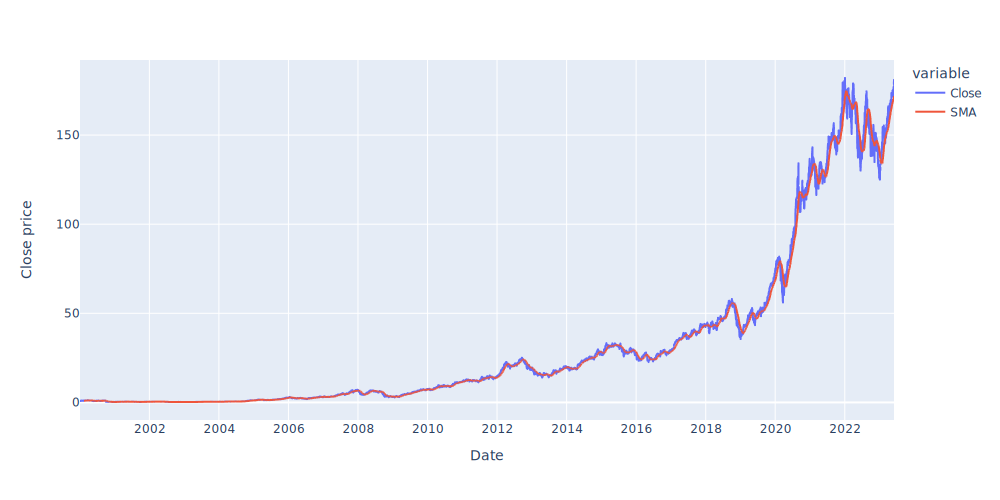

In [30]:
# When we plot the SMA or EMA with the closing price we can use a unique figure
fig = px.line(ind_data)
fig.update_xaxes(nticks = 20) #set the number of ticks for the x axis
fig.update_layout(height = 500, width = 1000)
fig.update_layout(yaxis_title='Close price')
fig.show(renderer='svg')


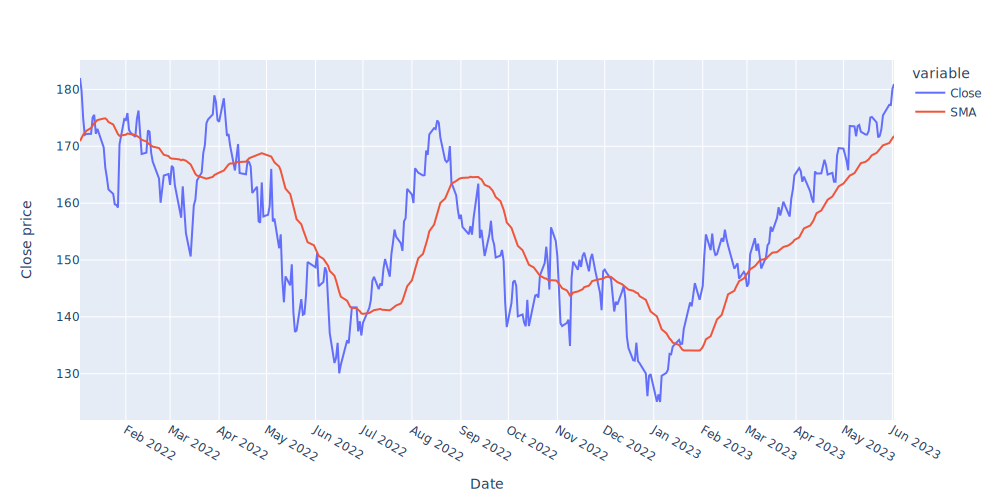

In [29]:
# Let's Zoom in a little
fig = px.line(ind_data['20220101':])
fig.update_xaxes(nticks = 20) #set the number of ticks for the x axis
fig.update_layout(height = 500, width = 1000)
fig.update_layout(yaxis_title='Close price')
fig.show(renderer='svg')

In [32]:
# Now we apply RSI
ind_data = apply_indicator(indicators[2], data, 30)
ind_data.tail()

,Close,RSI
Date,,
2023-05-26,175.429993,63.453175
2023-05-30,177.300003,66.861944
2023-05-31,177.250000,66.682843
2023-06-01,180.089996,71.373136
2023-06-02,180.949997,72.629679


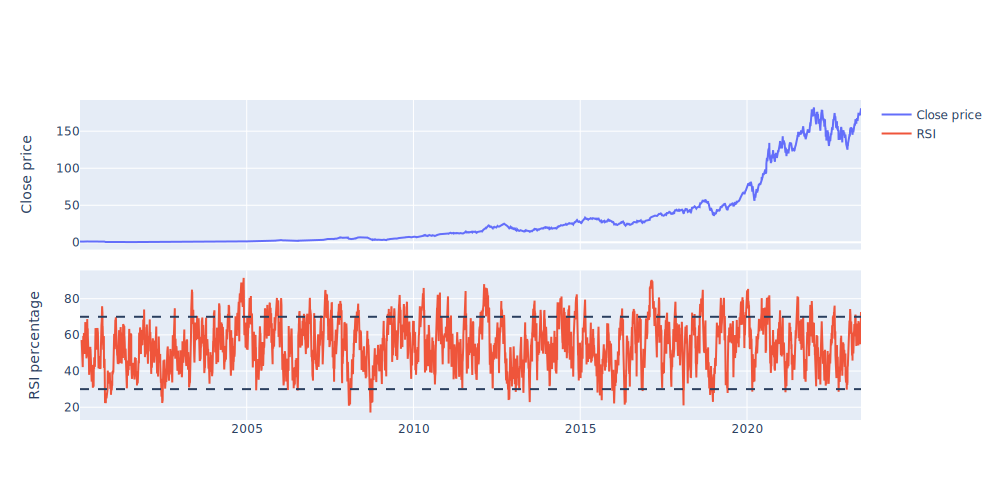

In [33]:
# Instead when selecting RSI as indicator we will plot two different figures (two traces) since the scale is different

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=1, vertical_spacing=0.065, shared_xaxes=True)

fig.add_trace(
    go.Scatter(x=ind_data.index, y=ind_data['Close'], name = 'Close price'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=ind_data.index, y=ind_data['RSI'], name = 'RSI'),
    row=2, col=1
)

fig.add_hline(
    y=70,
    line_dash="dash",
    row=2, col=1
)

fig.add_hline(
    y=30,
    line_dash="dash",
    row=2, col=1
)

fig['layout']['yaxis']['title']='Close price'
fig['layout']['yaxis2']['title']='RSI percentage'

fig.update_layout(height = 500, width = 1000)
fig.show(renderer='svg')